[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/mapelites.ipynb)

# Ask-Tell Interface for QDax with MAP-Elites

This notebook shows how to use QDax to find diverse and performing controllers in MDPs with [MAP-Elites](https://arxiv.org/abs/1504.04909), using the ask-tell interface.
It can be run locally or on Google Colab. We recommend to use a GPU. This notebook will show:

- how to define the problem
- how to create an emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process
- how to save/load a repertoire

In [1]:
from IPython.display import clear_output

try:
    import qdax
except:
    print("QDax not found. Installing...")
    !pip install qdax[cuda12]
    import qdax

clear_output()

In [2]:
!pip install ipympl | tail -n 1
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

import os

from IPython.display import clear_output
import functools
import time

import jax
import jax.numpy as jnp

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax import environments
from qdax.tasks.brax_envs import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results

from qdax.utils.metrics import CSVLogger, default_qd_metrics

from jax.flatten_util import ravel_pytree

from IPython.display import HTML
from brax.v1.io import html


if "COLAB_TPU_ADDR" in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

clear_output()

In [3]:
#@title QD Training Definitions Fields
#@markdown ---
batch_size = 100 #@param {type:"number"}
env_name = 'walker2d_uni'#@param['ant_uni', 'hopper_uni', 'walker2d_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
episode_length = 100 #@param {type:"integer"}
num_iterations = 100 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
policy_hidden_layer_sizes = (64, 64) #@param {type:"raw"}
iso_sigma = 0.005 #@param {type:"number"}
line_sigma = 0.05 #@param {type:"number"}
num_init_cvt_samples = 50000 #@param {type:"integer"}
num_centroids = 1024 #@param {type:"integer"}
min_descriptor = 0. #@param {type:"number"}
max_descriptor = 1.0 #@param {type:"number"}
#@markdown ---

## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [4]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)
reset_fn = jax.jit(env.reset)

# Init a random key
key = jax.random.key(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

## Define the way the policy interacts with the env

Now that the environment and policy has been defined, it is necessary to define a function that describes how the policy must be used to interact with the environment and to store transition data.

In [5]:
# Define the function to play a step with the policy in the environment
def play_step_fn(
    env_state,
    policy_params,
    key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)

    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, key, transition

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and descriptor of each individual.

In [6]:
# Prepare the scoring function
descriptor_extraction_fn = environments.descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function,
    episode_length=episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    descriptor_extractor=descriptor_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

## Define the emitter

The emitter is used to evolve the population at each mutation step.

In [7]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

mixing_emitter = MixingEmitter(
    mutation_fn=None,
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size
)

## Instantiate and initialise the MAP Elites algorithm

In [8]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=None,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
key, subkey = jax.random.split(key)
centroids = compute_cvt_centroids(
    num_descriptors=env.descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_descriptor,
    maxval=max_descriptor,
    key=subkey,
)

# Evaluate the initial population
key, subkey = jax.random.split(key)
fitnesses, descriptors, extra_scores = scoring_fn(init_variables, subkey)

# Compute initial repertoire and emitter state
repertoire, emitter_state = map_elites.init_ask_tell(
    genotypes=init_variables,
    fitnesses=fitnesses,
    descriptors=descriptors,
    centroids=centroids,
    key=key,
    extra_scores=extra_scores,
)

/home_nfs/paul/dev/QDax/qdax/core/map_elites.py:115: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


## Launch MAP-Elites iterations

In [9]:
metrics = dict.fromkeys(["iteration", "qd_score", "coverage", "max_fitness", "time"], jnp.array([]))
csv_logger = CSVLogger(
    "mapelites-logs.csv",
    header=list(metrics.keys())
)

# Add a progress bar if tqdm is installed
try:
    from tqdm import tqdm
    bar = tqdm(range(num_iterations))
except ImportError:
    bar = range(num_iterations)

# Main loop
for i in bar:
    start_time = time.time()
    key, subkey = jax.random.split(key)
    # Generate solutions
    genotypes, extra_info = map_elites.ask(repertoire, emitter_state, subkey)

    # Evaluate solutions: get fitness, descriptor and extra scores.
    # This is where custom evaluations on CPU or GPU can be added.
    key, subkey = jax.random.split(key)
    fitnesses, descriptors, extra_scores = scoring_fn(genotypes, subkey)

    # Update MAP-Elites
    repertoire, emitter_state, current_metrics = map_elites.tell(
        genotypes=genotypes,
        fitnesses=fitnesses,
        descriptors=descriptors,
        repertoire=repertoire,
        emitter_state=emitter_state,
        extra_scores=extra_scores,
        extra_info=extra_info,
    )

    timelapse = time.time() - start_time

    # Metrics
    current_metrics["iteration"] = i
    current_metrics["time"] =timelapse
    current_metrics = jax.tree.map(lambda x: jnp.array([x]), current_metrics)
    metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

    # Log
    csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

100%|██████████| 100/100 [00:30<00:00,  3.28it/s]


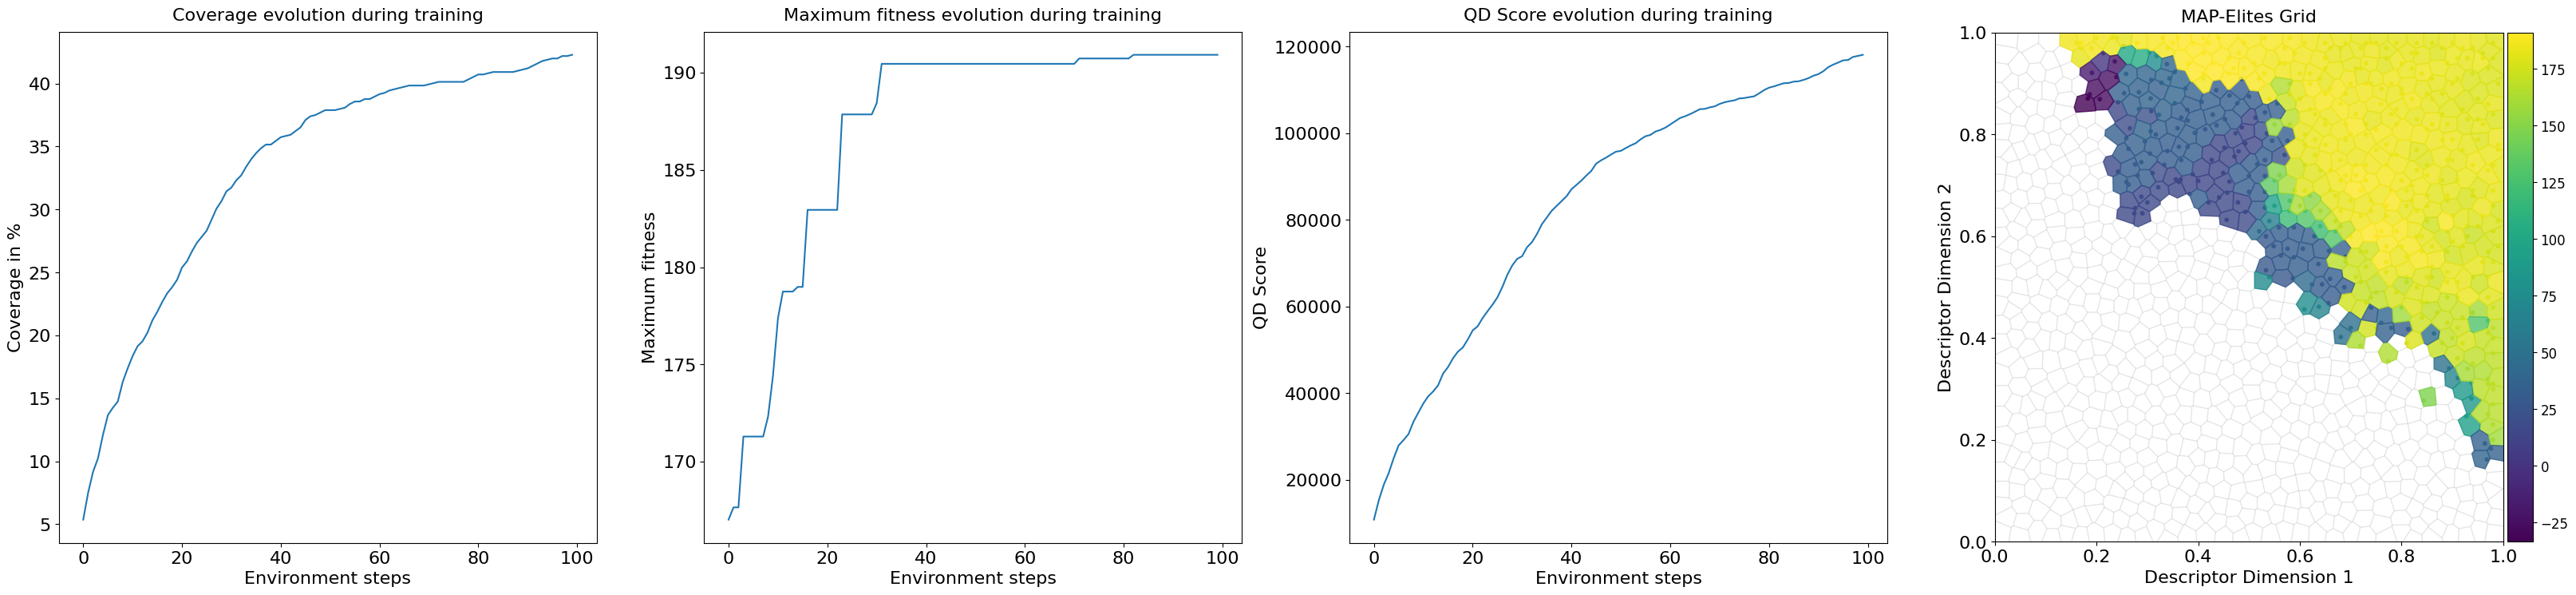

In [10]:
#@title Visualization

# Create the x-axis array
env_steps = metrics["iteration"]

%matplotlib inline
# Create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_descriptor=min_descriptor, max_descriptor=max_descriptor)